## Named Entity Recognition

Named Entity Recognition (NER) is used to identify and extract ingredients and their quantities from recipe texts. This technique is essential for automating ingredient extraction, which can be applied to tasks like cuisine classification, recipe recommendations, and ingredient-based analysis.

In [56]:
import pandas as pd
import sys
import numpy as np
import spacy
from spacy.language import Language
from spacy.tokens import Span
from spacy.matcher import Matcher
from spacy.matcher import PhraseMatcher
import random
from spacy.training import Example
from spacy.util import minibatch, compounding
from spacy.tokens import DocBin
import os
import matplotlib.pyplot as plt
from spacy.scorer import Scorer
from ner_recipe import *


## Load Data
Loading and preprocessing of the recipe data is the first step.
The dataset contains raw recipe text along with actual NER labels, which identify the ingredients and the feature that is combined, normalized text obtained after preprocessing

In [2]:
train_df = pd.read_csv('preprocessed_train_data_100k_version3.csv')

In [17]:
print(f'Length of train data is {len(train_df)}')
train_df.head()

Length of train data is 103271


,normalized_combined,filtered_NER
0,coconut crunch pie 4 egg whites 1 cup nuts 1 c...,"['sugar', 'vanilla', 'graham cracker crumbs', ..."
1,heirloom tomato gazpacho with lobster 8 large ...,"['creme fraiche', 'lobsters', 'lemon juice', '..."
2,waldorf salad serves 4 3 red apples 2 tablespo...,"['lemon juice', 'celery', 'red apples', 'mayon..."
3,pineapple cake 1 yellow cake mix 1 large can c...,"['pineapple', 'yellow cake']"
4,pecan pie 1 cup sugar 1 stick butter 2 eggs 1 ...,"['vinegar', 'sugar', 'vanilla', 'eggs', 'pecan..."


In [18]:
texts = train_df['normalized_combined'].tolist()
texts[0]

'coconut crunch pie 4 egg whites 1 cup nuts 1 cup sugar 1 cup coconut 1 cup graham cracker crumbs 1 teaspoon vanilla beat egg whites until frothy add sugar beat for 1 minute add other ingredients pour into buttered pie pan bake at 350 for 30 minutes top with sliced bananas and cool whip'

In [19]:
ner_tags = train_df['filtered_NER'].apply(eval).tolist()
ner_tags[10]

['green chilies',
 'kidney beans',
 'head lettuce',
 'tomatoes',
 'taco chips',
 'cheddar cheese',
 'onion',
 'ripe olives',
 'ground venison']

## Creating Patterns for Ingredient Extraction:

Based on the provided NER labels, patterns are created using SpaCy's Matcher. These patterns help to identify entities related to ingredients and quantities in the recipe texts.  
Ingredients are mapped to specific spans (start and end positions) in the text for accurate entity recognition.

In [20]:
nlp = spacy.blank("en")

# Create a dictionary of terms
terms = {}
patterns = []

for tags in ner_tags:
    for tag in tags:
        if tag not in terms:
            terms[tag] = {'label': 'INGREDIENT'}
            patterns.append(nlp(tag))

# Initialize the PhraseMatcher
ingredient_matcher = PhraseMatcher(nlp.vocab)
ingredient_matcher.add("INGREDIENT", None, *patterns)

In [21]:
patterns[:20]

[sugar,
 vanilla,
 graham cracker crumbs,
 egg whites,
 nuts,
 coconut,
 creme fraiche,
 lobsters,
 lemon juice,
 leeks,
 sherry vinegar,
 freshly ground black pepper,
 red jalapeno chile,
 red bell pepper,
 lime juice,
 white wine,
 kosher salt,
 yellow heirloom tomatoes,
 orange bell pepper,
 fresh cilantro]

In [22]:
len(patterns)

25680

In [26]:
#Checking that ner pipes don't have any components added at this stage
nlp.analyze_pipes()

{'summary': {}, 'problems': {}, 'attrs': {}}

In [27]:
# Quantity extractor component
@Language.component("quantity_extractor")
def quantity_extractor(doc):
    # Extract quantities
    matcher = Matcher(nlp.vocab)
    pattern = [
        {"LIKE_NUM": True},  # Match numbers
        {"LIKE_NUM": True, "OP": "?"},  # Match the second optional number (e.g., 8)
        {"LOWER": {"IN": ["cup", "tablespoon", "teaspoon", "ounce", "pound", "gram", "kilogram", "package", "quart", "liter", "milliliter"]}}
    ]
    matcher.add("QUANTITY", [pattern])
    matches = matcher(doc)
    quantity_spans = [Span(doc, start, end, label="QUANTITY") for match_id, start, end in matches]

    filtered_spans = spacy.util.filter_spans(quantity_spans)
   # Filter out existing QUANTITY entities
    new_ents = [ent for ent in doc.ents if ent.label_ != "QUANTITY"]

    # Add the unique quantity spans to the new_ents list
    doc.ents = new_ents + filtered_spans  # Add unique quantity spans

    return doc
nlp.add_pipe("quantity_extractor", last=True)  # Quantity extractor runs first


<function __main__.quantity_extractor(doc)>

In [28]:
# Ingredient extractor component
@Language.component("ingredient_extractor")
def ingredient_extractor(doc):
    # Extract ingredients after quantity extraction
    matches = ingredient_matcher(doc)
    spans = [Span(doc, start, end, label='INGREDIENT') for match_id, start, end in matches]

    unique_spans = []

    # Check if the ingredient overlaps with any quantity span before adding
    quantity_spans = [ent for ent in doc.ents if ent.label_ == "QUANTITY"]

    for span in spans:

        overlap_found = False

        # Check if the ingredient span overlaps with any quantity span
        for quantity in quantity_spans:
            if span.start < quantity.end and span.end > quantity.start:  # If overlap occurs
                overlap_found = True
                break  # Skip adding this ingredient if it overlaps with a quantity

        # Add ingredient span if there's no overlap with any quantity span
        if not overlap_found:
                unique_spans.append(span)


    # Resolve overlaps and filter out duplicate ingredient spans
    filtered_spans = spacy.util.filter_spans(unique_spans)
    new_ents = [ent for ent in doc.ents if ent.label_ != "INGREDIENT"]
    doc.ents = new_ents + filtered_spans  # Add unique ingredient spans, excluding overlapping ones

    return doc

nlp.add_pipe("ingredient_extractor", last=True)  # Ingredient extractor runs second



<function __main__.ingredient_extractor(doc)>

In [29]:
#Analyzing if Quantity and Ingredient Extractor components are added to pipe
nlp.analyze_pipes()

{'summary': {'quantity_extractor': {'assigns': [],
   'requires': [],
   'scores': [],
   'retokenizes': False},
  'ingredient_extractor': {'assigns': [],
   'requires': [],
   'scores': [],
   'retokenizes': False}},
 'problems': {'quantity_extractor': [], 'ingredient_extractor': []},
 'attrs': {}}

## Annotating Data for Training:

The raw text is annotated with start and end positions of ingredients and their corresponding labels.
Annotations are used to create training data in the SpaCy format and saved as a .spacy file (training_data.spacy), which is later used for model training.

In [27]:
from spacy.tokens import DocBin

train_data = [(text, {"entities": []}) for text in texts]

for i, (text, annotations) in enumerate(train_data):
    doc = nlp(text)
    entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    train_data[i] = (text, {"entities": entities})


In [37]:
train_data[0]

('coconut crunch pie 4 egg whites 1 cup nuts 1 cup sugar 1 cup coconut 1 cup graham cracker crumbs 1 teaspoon vanilla beat egg whites until frothy add sugar beat for 1 minute add other ingredients pour into buttered pie pan bake at 350 for 30 minutes top with sliced bananas and cool whip',
 {'entities': [(0, 7, 'INGREDIENT'),
   (15, 18, 'INGREDIENT'),
   (21, 31, 'INGREDIENT'),
   (32, 37, 'QUANTITY'),
   (38, 42, 'INGREDIENT'),
   (43, 48, 'QUANTITY'),
   (49, 54, 'INGREDIENT'),
   (55, 60, 'QUANTITY'),
   (61, 68, 'INGREDIENT'),
   (69, 74, 'QUANTITY'),
   (75, 96, 'INGREDIENT'),
   (97, 107, 'QUANTITY'),
   (108, 115, 'INGREDIENT'),
   (121, 131, 'INGREDIENT'),
   (149, 154, 'INGREDIENT'),
   (214, 217, 'INGREDIENT'),
   (265, 272, 'INGREDIENT'),
   (277, 286, 'INGREDIENT')]})

In [30]:
#Save the training data
save_training_data(train_data, 'training_data.spacy')

## Training the SpaCy Model:

A blank SpaCy model is trained using the annotated data.
Training is done with mini-batch compounding, with parameters such as a batch size of 32, a learning rate of 4.0, and a dropout rate of 1.5.
To avoid overfitting, an early stopping mechanism is applied. Training stops if the loss does not improve for 10 consecutive iterations (with a threshold of 5000).


In [ ]:
# Iterate over four different parameter sets
parameter_sets = [
    {"max_iterations": 40, "initial_lr": 1e-3, "dropout_rate": 0.5, "min_loss_improvement": 7000, "patience": 6, "decay_interval":5},
    {"max_iterations": 35, "initial_lr": 5e-3, "dropout_rate": 0.5, "min_loss_improvement": 7500, "patience": 6, "decay_interval":5},
    {"max_iterations": 35, "initial_lr": 1e-2, "dropout_rate": 0.5, "min_loss_improvement": 5000, "patience": 6, "decay_interval":5},
    {"max_iterations": 35, "initial_lr": 1e-2, "dropout_rate": 0.6, "min_loss_improvement": 6000, "patience": 5, "decay_interval":4}
]


def train_ner_model(training_data_path, output_model_path, max_iterations, initial_lr, dropout_rate, min_loss_improvement, patience, decay_interval):
    # Load the training data
    nlp = spacy.blank("en")  # Using a blank 'en' model
    db = DocBin().from_disk(training_data_path)
    docs = list(db.get_docs(nlp.vocab))

    # Create the NER component and add it to the pipeline
    if 'ner' not in nlp.pipe_names:
        ner = nlp.add_pipe("ner", last=True)

    # Add the labels to the NER component
    for doc in docs:
        for ent in doc.ents:
            ner.add_label(ent.label_)

    # Disable other pipes during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):
        optimizer = nlp.begin_training()

        prev_loss = None  # Track the previous loss
        no_improvement_counter = 0  # Counter for early stopping
        losses_history = []  # Track losses for plotting

        # Set an initial learning rate
        optimizer.learn_rate = initial_lr

        for itn in range(max_iterations):
            random.shuffle(docs)
            losses = {}
            batches = minibatch(docs, size=compounding(4.0, 32.0, 1.5))

            for batch in batches:
                examples = [Example.from_dict(doc, {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}) for doc in batch]
                nlp.update(examples, drop=dropout_rate, losses=losses)

            losses_history.append(losses['ner'])
            print(f"Iteration {itn}, Losses: {losses}")

            # Slower learning rate decay
            if itn % decay_interval == 0:
                new_lr = initial_lr * (0.5 ** (itn // decay_interval))
                optimizer.learn_rate = new_lr
                print(f"Updated learning rate to: {new_lr}")

            # Check for improvement in loss
            if prev_loss is not None:
                improvement = prev_loss - losses['ner']
                print(f"Improvement in this iteration: {improvement}")

                if improvement < min_loss_improvement:
                    no_improvement_counter += 1
                    if no_improvement_counter >= patience:
                        print(f"Stopping early due to small improvement over {patience} iterations.")
                        break
                else:
                    no_improvement_counter = 0

            prev_loss = losses['ner']

        # Save the trained model to disk
        nlp.to_disk(output_model_path)

    return losses_history


for i, params in enumerate(parameter_sets):
    print(f"Training with parameter set {i + 1}: {params}")
    losses = train_ner_model(
        training_data_path="training_data.spacy",
        output_model_path=f"ner_model_{i + 1}",
        max_iterations=params["max_iterations"],
        initial_lr=params["initial_lr"],
        dropout_rate=params["dropout_rate"],
        min_loss_improvement=params["min_loss_improvement"],
        patience=params["patience"],
        decay_interval=params["decay_interval"]
    )
    

Training with parameter set 1: {'max_iterations': 40, 'initial_lr': 0.001, 'dropout_rate': 0.5, 'min_loss_improvement': 7000, 'patience': 6, 'decay_interval': 5}


/courses/IE7500.202530/shared/conda_env_1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Iteration 0, Losses: {'ner': 645946.4055677251}
Updated learning rate to: 0.001
Iteration 1, Losses: {'ner': 365621.14076507743}
Improvement in this iteration: 280325.26480264764
Iteration 2, Losses: {'ner': 321061.8127209459}
Improvement in this iteration: 44559.328044131515
Iteration 3, Losses: {'ner': 295304.4009300095}
Improvement in this iteration: 25757.41179093643
Iteration 4, Losses: {'ner': 279023.8680777341}
Improvement in this iteration: 16280.532852275413
Iteration 5, Losses: {'ner': 266658.05974608567}
Updated learning rate to: 0.0005
Improvement in this iteration: 12365.808331648412
Iteration 6, Losses: {'ner': 248052.99423417123}
Improvement in this iteration: 18605.065511914436
Iteration 7, Losses: {'ner': 240563.10001121397}
Improvement in this iteration: 7489.894222957257
Iteration 8, Losses: {'ner': 235308.79028505273}
Improvement in this iteration: 5254.309726161242
Iteration 9, Losses: {'ner': 231831.3897482939}
Improvement in this iteration: 3477.400536758825
Iter

## Prediction on Test Data:

After training, the model is used to predict ingredients and quantities on preprocessed test data.  
The predicted entities are extracted for further analysis, such as cuisine classification.

In [4]:
import pandas as pd
test_df = pd.read_csv('test_data_100k_version3.csv')
test_df = test_df.rename(columns={'actual_NER': 'filtered_NER'})
test_df.head()

,test_recipe,filtered_NER
0,sour cream green beans 0.5 cup thinly sliced o...,"['sour cream', 'onion soup', 'onion', 'mushroo..."
1,great fluff 7 ounce marshmallows 2 tablespoon ...,"['milk', 'brown sugar', 'marshmallows', 'unsal..."
2,fruit punch 1 can frozen orange juice 1 can fr...,"['sugar', 'water', 'pineapple juice', 'orange ..."
3,crabmeat casserole serves 10 1 pt mayonnaise 1...,"['fresh crabmeat', 'stuffing mix', 'eggs', 'on..."
4,georgia peach-glazed pork roast 1 2 to 2.5 pou...,"['pork loin roast', 'cinnamon', 'peach preserv..."


In [8]:
import spacy

# Iterate over the models and apply them to test_df
for i in range(1, 5):
    model_path = f"ner_model_{i}"
    print(f"Testing model: {model_path}")
    
    try:
        nlp = spacy.load(model_path)
    except Exception as e:
        print(f"Error loading model {model_path}: {e}")
        continue
    
    # Apply the test_ner function to the test_df with the specific nlp model
    test_df[f'predicted_ingredients_model_{i}'], test_df[f'predicted_quantities_model_{i}'] = zip(
        *test_df['test_recipe'].apply(lambda x: test_ner(x, nlp))
    )


Testing model: ner_model_1
Testing model: ner_model_2
Testing model: ner_model_3
Testing model: ner_model_4


In [50]:
pd.set_option('display.max_colwidth',None)
test_df.head()

,test_recipe,filtered_NER,predicted_ingredients_model_1,predicted_quantities_model_1,predicted_ingredients_model_2,predicted_quantities_model_2,predicted_ingredients_model_3,predicted_quantities_model_3,predicted_ingredients_model_4,predicted_quantities_model_4
0,sour cream green beans 0.5 cup thinly sliced onion 8 ounce sliced mushrooms 0.25 cup butter 2 10 ounce packages green beans 1 cup sour cream 1 5 ounce package dry onion soup mix salt and pepper to taste 1 cup shredded cheese any kind you like 1 cup breadcrumbs pre heat oven to 350 . saute onions and mushrooms in butter in a bowl combine beans sour cream onion soup mix salt pepper mix lightly fold in cheese pour into a greased 2 quart casserole mix melted butter with bread crumbs top the beans when mixed bake for 20 25 until bubbly,"['sour cream', 'onion soup', 'onion', 'mushrooms', 'shredded cheese', 'breadcrumbs', 'green beans', 'butter', 'salt']","{butter, mushrooms, green beans, salt, breadcrumbs, bread crumbs, onion, onion soup mix, pepper, shredded cheese, salt pepper, sour cream, beans, cheese, onions}","{0.25 cup, 2 10 ounce, 2 quart, 1 cup, 1 5 ounce, 0.5 cup, 8 ounce}","{butter, mushrooms, green beans, salt, breadcrumbs, bread crumbs, onion, onion soup mix, pepper, shredded cheese, salt pepper, sour cream, beans, cheese, onions}","{0.25 cup, 2 10 ounce, 2 quart, 1 cup, 1 5 ounce, 0.5 cup, 8 ounce}","{butter, mushrooms, green beans, salt, breadcrumbs, bread crumbs, onion, onion soup mix, pepper, shredded cheese, salt pepper, sour cream, beans, cheese, onions}","{0.25 cup, 2 10 ounce, 2 quart, 1 cup, 1 5 ounce, 0.5 cup, 8 ounce}","{butter, mushrooms, green beans, salt, breadcrumbs, bread crumbs, onion, onion soup mix, pepper, shredded cheese, salt pepper, sour cream, beans, cheese, onions}","{0.25 cup, 2 10 ounce, 2 quart, 1 cup, 1 5 ounce, 0.5 cup, 8 ounce}"
1,great fluff 7 ounce marshmallows 2 tablespoon unsalted butter 12 cup brown sugar 1 cup evaporated milk first add sugar marshmallows and milk to a pot then wait till boiling when done bowling add in the marshmallows finally wait till the marshmallows melt in the bowling liquid then enjoy you yummy tasting fluff,"['milk', 'brown sugar', 'marshmallows', 'unsalted butter']","{marshmallows, evaporated milk, milk, sugar, brown sugar, unsalted butter}","{12 cup, 2 tablespoon, 7 ounce, 1 cup}","{marshmallows, evaporated milk, milk, sugar, brown sugar, unsalted butter}","{12 cup, 2 tablespoon, 7 ounce, 1 cup}","{marshmallows, evaporated milk, milk, sugar, brown sugar, unsalted butter}","{12 cup, 2 tablespoon, 7 ounce, 1 cup}","{marshmallows, evaporated milk, milk, sugar, brown sugar, unsalted butter}","{12 cup, 2 tablespoon, 7 ounce, 1 cup}"
2,fruit punch 1 can frozen orange juice 1 can frozen lemonade 4 cup sugar 1 quart pineapple juice 6 quart water 2 large ginger ale 6 small bottles 7 up thaw juices mix first 5 ingredients and stir until sugar is dissolved add ginger ale and 7 up fills large punch bowl,"['sugar', 'water', 'pineapple juice', 'orange juice', 'frozen lemonade', 'ginger ale']","{pineapple juice, orange juice, water, sugar, ginger ale, frozen lemonade, fruit punch}","{1 quart, 4 cup, 6 quart}","{pineapple juice, orange juice, water, sugar, ginger ale, frozen lemonade, fruit punch}","{1 quart, 4 cup, 6 quart}","{pineapple juice, orange juice, water, sugar, ginger ale, frozen lemonade, fruit punch}","{1 quart, 4 cup, 6 quart}","{fruit, pineapple juice, orange juice, water, sugar, ginger ale, frozen lemonade}","{1 quart, 4 cup, 6 quart}"
3,crabmeat casserole serves 10 1 pt mayonnaise 1 pt cream 1 pound fresh crabmeat 2 tablespoon chopped parsley 2 tablespoon chopped onion 3 hard-boiled eggs coarsely chopped 0.5 cup sherry taylor dry 1 package stuffing mix bake 45 minutes at 300 mix all together except stuffing and place on casserole dish you can place stuffing mix on top of mixture then bake 45 minutes at 300,"['fresh crabmeat', 'stuffing mix', 'eggs', 'onion', 'sherry', 'mayonnaise', 'parsley', 'crea

In [11]:
pd.set_option('display.max_colwidth', None)
for i in range(1, 5):
    test_df[f'predicted_ingredients_model_{i}'].to_csv(f'predicted_ingredients_model_{i}.csv', index=False)

## Evaluation of Model Performance:

The model’s performance is evaluated by comparing predicted ingredients with actual ground truth labels from the test data.  
Test data's predicted and actual NER values are prepared in a way Spacy can understand and therefore annotations are used.  
This comparison is made by annotating raw text with the predicted entities and their corresponding labels.  
SpaCy’s Scorer is used to calculate performance metrics such as precision, recall, and F1 scores, which reflect the model’s ability to accurately extract ingredients and quantities.

In [14]:
test_df.columns

Index(['test_recipe', 'filtered_NER', 'predicted_ingredients_model_1',
       'predicted_quantities_model_1', 'predicted_ingredients_model_2',
       'predicted_quantities_model_2', 'predicted_ingredients_model_3',
       'predicted_quantities_model_3', 'predicted_ingredients_model_4',
       'predicted_quantities_model_4'],
      dtype='object')

## Preparing the data for actual NER labels to compare with the predicted labels
Creating annotation for the actual NER values

In [30]:
texts = test_df['test_recipe'].tolist()
ner_tags = test_df['filtered_NER'].apply(eval).tolist()

nlp = spacy.blank("en")

# Create a dictionary of terms
terms = {}
patterns = []

for tags in ner_tags:
    for tag in tags:
        if tag not in terms and tag!='mix':
            terms[tag] = {'label': 'INGREDIENT'}
            patterns.append(nlp(tag))

# Initialize the PhraseMatcher
ingredient_matcher = PhraseMatcher(nlp.vocab)
ingredient_matcher.add("INGREDIENT", None, *patterns)

In [31]:
patterns[:10]

[sour cream,
 onion soup,
 onion,
 mushrooms,
 shredded cheese,
 breadcrumbs,
 green beans,
 butter,
 salt,
 milk]

In [32]:
#Calling the quantity_extractor component to add to ner pipe
nlp.add_pipe("quantity_extractor", last=True)

<function __main__.quantity_extractor(doc)>

In [33]:
#Calling the ingredient_extractor component to add to ner pipe
nlp.add_pipe("ingredient_extractor", last=True)

<function __main__.ingredient_extractor(doc)>

In [34]:
nlp.analyze_pipes()

{'summary': {'quantity_extractor': {'assigns': [],
   'requires': [],
   'scores': [],
   'retokenizes': False},
  'ingredient_extractor': {'assigns': [],
   'requires': [],
   'scores': [],
   'retokenizes': False}},
 'problems': {'quantity_extractor': [], 'ingredient_extractor': []},
 'attrs': {}}

In [35]:
#Creating annotations for actual NER labels
from spacy.tokens import DocBin

actual_data = [(text, {"entities": []}) for text in texts]

for i, (text, annotations) in enumerate(actual_data):
    doc = nlp(text)
    entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    actual_data[i] = (text, {"entities": entities})

In [37]:
actual_data[1]

('great fluff 7 ounce marshmallows 2 tablespoon unsalted butter 12 cup brown sugar 1 cup evaporated milk first add sugar marshmallows and milk to a pot then wait till boiling when done bowling add in the marshmallows finally wait till the marshmallows melt in the bowling liquid then enjoy you yummy tasting fluff',
 {'entities': [(12, 19, 'QUANTITY'),
   (20, 32, 'INGREDIENT'),
   (33, 45, 'QUANTITY'),
   (46, 61, 'INGREDIENT'),
   (62, 68, 'QUANTITY'),
   (69, 80, 'INGREDIENT'),
   (81, 86, 'QUANTITY'),
   (87, 102, 'INGREDIENT'),
   (113, 118, 'INGREDIENT'),
   (119, 131, 'INGREDIENT'),
   (136, 140, 'INGREDIENT'),
   (146, 149, 'INGREDIENT'),
   (202, 214, 'INGREDIENT'),
   (237, 249, 'INGREDIENT')]})

In [46]:
parameter_sets = [
    {"max_iterations": 40, "initial_lr": 1e-3, "dropout_rate": 0.5, "min_loss_improvement": 7000, "patience": 6, "decay_interval":5},
    {"max_iterations": 35, "initial_lr": 5e-3, "dropout_rate": 0.5, "min_loss_improvement": 7500, "patience": 6, "decay_interval":5},
    {"max_iterations": 35, "initial_lr": 1e-2, "dropout_rate": 0.5, "min_loss_improvement": 5000, "patience": 6, "decay_interval":5},
    {"max_iterations": 35, "initial_lr": 1e-2, "dropout_rate": 0.6, "min_loss_improvement": 6000, "patience": 5, "decay_interval":4}
]

precisions = []
recalls = []
f1_scores = []

for i in range(1, 5):
        print(f"Evaluating model: ner_model_{i}")
        model_path = f"ner_model_{i}"
        nlp = spacy.load(model_path)

        metrics = evaluate_model(test_df['test_recipe'].tolist(), actual_data)

        scorer = Scorer()
        metrics = scorer.score(examples)

        precision, recall, f1_score = save_metrics_and_plot(parameter_sets, metrics)
        
        # Append metrics to lists for plotting
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)

Evaluating model: ner_model_1
Metrics for model 1: {'token_acc': 1.0, 'token_p': 1.0, 'token_r': 1.0, 'token_f': 1.0, 'sents_p': None, 'sents_r': None, 'sents_f': None, 'tag_acc': None, 'pos_acc': None, 'morph_acc': None, 'morph_micro_p': None, 'morph_micro_r': None, 'morph_micro_f': None, 'morph_per_feat': None, 'dep_uas': None, 'dep_las': None, 'dep_las_per_type': None, 'ents_p': 0.9235910071866141, 'ents_r': 0.9266979578577109, 'ents_f': 0.9251418739721861, 'ents_per_type': {'INGREDIENT': {'p': 0.8998096716103245, 'r': 0.9037819030981077, 'f': 0.901791413131356}, 'QUANTITY': {'p': 0.9999717863474135, 'r': 0.9999764885122872, 'f': 0.9999741374243226}}, 'cats_score': 0.0, 'cats_score_desc': 'macro F', 'cats_micro_p': 0.0, 'cats_micro_r': 0.0, 'cats_micro_f': 0.0, 'cats_macro_p': 0.0, 'cats_macro_r': 0.0, 'cats_macro_f': 0.0, 'cats_macro_auc': 0.0, 'cats_f_per_type': {}, 'cats_auc_per_type': {}}
Evaluating model: ner_model_2
Metrics for model 2: {'token_acc': 1.0, 'token_p': 1.0, 'toke

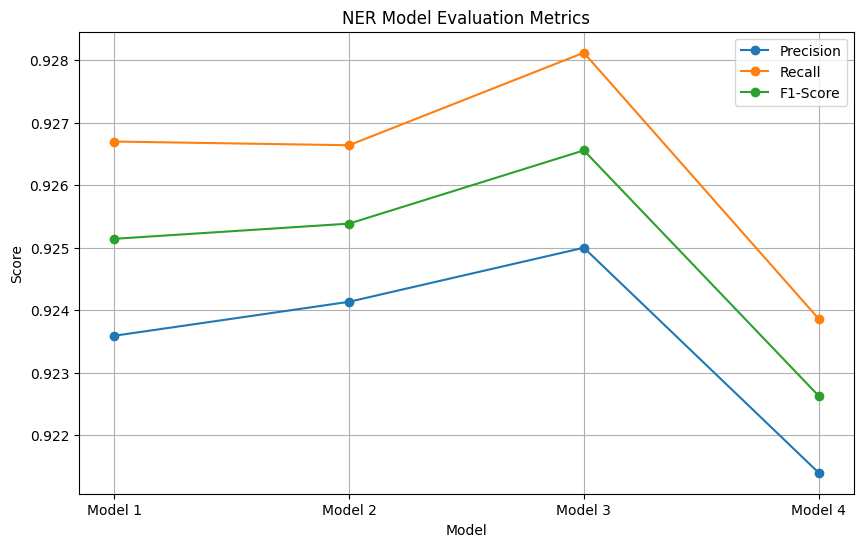

In [52]:
#Plot NER model evaluation metrics
plot_metrics(precisions, recalls, f1_scores)

## Testing on raw sample data

In [49]:
import pandas as pd
import spacy
from spacy import displacy

# Load your SpaCy model
nlp = spacy.load("ner_model_3")

# List of recipes and their ingredients (with quantities) in the format of raw text
recipes = [
    {"recipe_name": "Mexican Tacos", "recipe_text": "For the tacos, you will need 1 cup of salsa, 2 tablespoon of chopped cilantro, and 1 teaspoon of chili powder. Serve the tacos with 1 pound of ground beef, and garnish with 0.5 cup of shredded cheese."},
    {"recipe_name": "Italian Margherita Pizza", "recipe_text": "For the pizza, you'll need 200 gram of mozzarella cheese, 1 cup of tomato sauce, and 2 teaspoon of dried oregano. Use 1 tablespoon of olive oil to coat the dough before baking."},
    {"recipe_name": "American Pancakes", "recipe_text": "To make pancakes, combine 1 cup of flour, 2 tablespoon of sugar, and 1 teaspoon of vanilla extract. Add 0.5 cup of milk and 0.5 cup of melted butter to the batter, then cook on a hot griddle."},
    {"recipe_name": "Chinese Fried Rice", "recipe_text": "For the fried rice, start with 2 cups of cooked rice, 0.5 cup of peas and carrots, and 2 tablespoon of soy sauce. Add 0.5 cup of chopped green onions and 1 teaspoon of sesame oil. Stir-fry until golden."},
    {"recipe_name": "Japanese Ramen", "recipe_text": "For the ramen, heat 1 liter of chicken broth and add 2 tablespoons of soy sauce. Add 3 ounces of ramen noodles and 0.5 teaspoon of miso paste. Simmer for 10 minutes, then garnish with 0.25 cup of chopped green onions."},
    {"recipe_name": "Indian Chole Bhature", "recipe_text": "For the chole, cook 1 cup of chickpeas and mix with 2 tablespoon of cumin powder and 1 teaspoon of coriander powder. Serve with 1 teaspoon of garam masala and 0.5 cup of chopped cilantro. Fry the bhature in 0.5 cup of oil until golden brown."}
]

# Convert recipes into a DataFrame
df_recipes = pd.DataFrame(recipes)

# Assuming you have a trained NER model (nlp), we can iterate over the recipes and display using displacy
for index, row in df_recipes.iterrows():
    recipe_text = row['recipe_text']
    recipe_name = row['recipe_name']

    # Process the recipe text through the model
    doc = nlp(recipe_text)

    # Print the recipe name
    print(f"Recipe: {recipe_name}")

    # Visualize the identified entities using displacy
    print(f"Visualizing Entities for {recipe_name}")
    displacy.render(doc, style='ent', page=True)  # page=True will open it in the browser or a Jupyter notebook

    # Add a line for separation between recipes
    print("\n" + "-"*50 + "\n")


Recipe: Mexican Tacos
Visualizing Entities for Mexican Tacos



--------------------------------------------------

Recipe: Italian Margherita Pizza
Visualizing Entities for Italian Margherita Pizza



--------------------------------------------------

Recipe: American Pancakes
Visualizing Entities for American Pancakes



--------------------------------------------------

Recipe: Chinese Fried Rice
Visualizing Entities for Chinese Fried Rice



--------------------------------------------------

Recipe: Japanese Ramen
Visualizing Entities for Japanese Ramen



--------------------------------------------------

Recipe: Indian Chole Bhature
Visualizing Entities for Indian Chole Bhature



--------------------------------------------------

